# Определение перспективного тарифа для телеком-компании

Вы аналитик компании «Мегалайн» — федерального оператора сотовой связи. Клиентам предлагают два тарифных плана: «Смарт» и «Ультра». Чтобы скорректировать рекламный бюджет, коммерческий департамент хочет понять, какой тариф приносит больше денег.
Вам предстоит сделать предварительный анализ тарифов на небольшой выборке клиентов. В вашем распоряжении данные 500 пользователей «Мегалайна»: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. Нужно проанализировать поведение клиентов и сделать вывод — какой тариф лучше.

## Изучение данных из файлов

In [1]:
# импорт библиотек
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import math
from scipy import stats as st

In [2]:
# сделаем так, чтобы jupyter не выдавал ошибки
import warnings

warnings.filterwarnings("ignore")

Всего имеется шесть файлов: таблица `users` с информацией о пользователях, таблица `calls` с информацией о звонках, таблица `messages` с информацией о сообщениях, таблица `internet` с информацией об интернет-сессиях, таблица `tariffs` с информацией о тарифах. Объединим их в одну общую для удобства.

In [3]:
users_data = pd.read_csv('users.csv')
display(users_data.info())

messages_data = pd.read_csv('messages.csv')
display(messages_data.info())

internet_data = pd.read_csv('internet.csv', index_col=0)
display(internet_data.info())

calls_data = pd.read_csv('calls.csv')
display(calls_data.info())

tariffs_data = pd.read_csv('tariffs.csv')
display(tariffs_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   age         500 non-null    int64 
 2   churn_date  38 non-null     object
 3   city        500 non-null    object
 4   first_name  500 non-null    object
 5   last_name   500 non-null    object
 6   reg_date    500 non-null    object
 7   tariff      500 non-null    object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            123036 non-null  object
 1   message_date  123036 non-null  object
 2   user_id       123036 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


None

<class 'pandas.core.frame.DataFrame'>
Int64Index: 149396 entries, 0 to 149395
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            149396 non-null  object 
 1   mb_used       149396 non-null  float64
 2   session_date  149396 non-null  object 
 3   user_id       149396 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 5.7+ MB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         202607 non-null  object 
 1   call_date  202607 non-null  object 
 2   duration   202607 non-null  float64
 3   user_id    202607 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   messages_included      2 non-null      int64 
 1   mb_per_month_included  2 non-null      int64 
 2   minutes_included       2 non-null      int64 
 3   rub_monthly_fee        2 non-null      int64 
 4   rub_per_gb             2 non-null      int64 
 5   rub_per_message        2 non-null      int64 
 6   rub_per_minute         2 non-null      int64 
 7   tariff_name            2 non-null      object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


None

Согласно документации к данным:

Таблица `users` (информация о пользователях):
* user_id — уникальный идентификатор пользователя
* first_name — имя пользователя
* last_name — фамилия пользователя
* age — возраст пользователя (годы)
* reg_date — дата подключения тарифа (день, месяц, год)
* churn_date — дата прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных)
* city — город проживания пользователя
* tariff — название тарифного плана

Таблица `calls` (информация о звонках):
* id — уникальный номер звонка
* call_date — дата звонка
* duration — длительность звонка в минутах
* user_id — идентификатор пользователя, сделавшего звонок

Таблица `messages` (информация о сообщениях):
* id — уникальный номер сообщения
* message_date — дата сообщения
* user_id — идентификатор пользователя, отправившего сообщение

Таблица `internet` (информация об интернет-сессиях):
* id — уникальный номер сессии
* mb_used — объём потраченного за сессию интернет-трафика (в мегабайтах)
* session_date — дата интернет-сессии
* user_id — идентификатор пользователя

Таблица `tariffs` (информация о тарифах):
* tariff_name — название тарифа
* rub_monthly_fee — ежемесячная абонентская плата в рублях
* minutes_included — количество минут разговора в месяц, включённых в абонентскую плату
* messages_included — количество сообщений в месяц, включённых в абонентскую плату
* mb_per_month_included — объём интернет-трафика, включённого в абонентскую плату (в мегабайтах)
* rub_per_minute — стоимость минуты разговора сверх тарифного пакета (например, если в тарифе 100 минут разговора в месяц, то со 101 минуты будет взиматься плата)
* rub_per_message — стоимость отправки сообщения сверх тарифного пакета
* rub_per_gb — стоимость дополнительного гигабайта интернет-трафика сверх тарифного пакета (1 гигабайт = 1024 мегабайта)

Представим данные визуально:

In [4]:
display(tariffs_data.head())
display(users_data.head())
display(internet_data.head())
display(calls_data.head())
display(messages_data.head())

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


,id,mb_used,session_date,user_id
0,1000_0,112.95,2018-11-25,1000
1,1000_1,1052.81,2018-09-07,1000
2,1000_2,1197.26,2018-06-25,1000
3,1000_3,550.27,2018-08-22,1000
4,1000_4,302.56,2018-09-24,1000


,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000


,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000


Сделаем математическое описание некоторых столбцов:

In [5]:
display(internet_data['mb_used'].describe())
calls_data['duration'].describe()

count    149396.000000
mean        370.192426
std         278.300951
min           0.000000
25%         138.187500
50%         348.015000
75%         559.552500
max        1724.830000
Name: mb_used, dtype: float64

count    202607.000000
mean          6.755887
std           5.843365
min           0.000000
25%           1.300000
50%           6.000000
75%          10.700000
max          38.000000
Name: duration, dtype: float64

В таблице `tariffs` есть столбец **mb_per_month_included**, где указаны расчеты в мегабайтах - переведем числа в гигабайты и изменим название столбца. В таблице `users` в столбце **churn_date** есть пропуски. Согласно документации, удалять или заменять значения в ней не нужно, так как это не ошибка.  В таблице `calls` есть нулевые значения для длительности звонков - тоже не ошибка, так как нулями обозначены пропущенные звонки, поэтому их не нужно удалять. Также в этом столбце округим длительность до минуты, даже если звонок длился несколько секунд. То же самое повторим для **mb_used** в `internet` - округлим до гигабайтов и изменим название столбца. В таблице `internet` имеется выбивающийся столбец **Unnamed: 0**. Похоже, заполнявший данные вынес индексы строк в отдельный столбец. Во всех столбцах, где указана дата, типом данных является **object** - заменим на **datetime**. 

Исходя из описанных данных, **среднее** использование интернета за одну сессию - 371 мб, **медиана** - 349 мб, **стандартное отклонение** - 279 мб. **Средний** звонок длится 7 минут, **медиана** - 6 минут, **стандартное отклонение** - 6 минут. 

##### Вывод

В файлах содержатся данные об использовании сети для коммуникации - интернет, звонки, сообщения. Таблицe `tariffs` является словарем с данными о тарифах. Необходимой информации для проведения исследования хватает, однако в данных имеются проблемы: выбивающийся столбец, требующие округления данные, требующие изменения типы данных. Также потребуется объединить остальные столбцы в один для удобства работы. 

## Предобработка данных


### Объединение таблиц

Для удобства работы с данными, объеденим несколько столбцов в один:

In [6]:
total_data = pd.merge(calls_data, messages_data, on=['user_id', 'id'], how='left')
total_data = pd.merge(total_data, internet_data, on=['user_id', 'id'], how='left')
total_data = pd.merge(total_data, users_data, on=['user_id'], how='left')
# изменим порядок столбцов для читаемости
total_data = total_data[[
    'user_id', 'id', 'first_name', 'last_name', 'age', 'city', 'reg_date', 'churn_date', 'tariff', 'session_date', 'mb_used', 'call_date', 'duration', 'message_date'
]]
total_data.head()

,user_id,id,first_name,last_name,age,city,reg_date,churn_date,tariff,session_date,mb_used,call_date,duration,message_date
0,1000,1000_0,Рафаил,Верещагин,52,Краснодар,2018-05-25,NaN,ultra,2018-11-25,112.95,2018-07-25,0.00,2018-06-27
1,1000,1000_1,Рафаил,Верещагин,52,Краснодар,2018-05-25,NaN,ultra,2018-09-07,1052.81,2018-08-17,0.00,2018-10-08
2,1000,1000_2,Рафаил,Верещагин,52,Краснодар,2018-05-25,NaN,ultra,2018-06-25,1197.26,2018-06-11,2.85,2018-08-04
3,1000,1000_3,Рафаил,Верещагин,52,Краснодар,2018-05-25,NaN,ultra,2018-08-22,550.27,2018-09-21,13.80,2018-06-16
4,1000,1000_4,Рафаил,Верещагин,52,Краснодар,2018-05-25,NaN,ultra,2018-09-24,302.56,2018-12-15,5.18,2018-12-05


### Округление данных

Требуется округлить данные в большую сторону, так как «Мегалайн» всегда округляет секунды до минут, а мегабайты — до гигабайт. Для этого применим метод **ceil()**. 

In [7]:
# предварительно разделим значения на 1024, чтобы перевести данные в гигабайты
total_data['mb_used'] = total_data['mb_used'] / 1024 

In [8]:
total_data['duration'] = np.ceil(total_data['duration']).astype(int)
total_data.head()

,user_id,id,first_name,last_name,age,city,reg_date,churn_date,tariff,session_date,mb_used,call_date,duration,message_date
0,1000,1000_0,Рафаил,Верещагин,52,Краснодар,2018-05-25,NaN,ultra,2018-11-25,0.110303,2018-07-25,0,2018-06-27
1,1000,1000_1,Рафаил,Верещагин,52,Краснодар,2018-05-25,NaN,ultra,2018-09-07,1.028135,2018-08-17,0,2018-10-08
2,1000,1000_2,Рафаил,Верещагин,52,Краснодар,2018-05-25,NaN,ultra,2018-06-25,1.169199,2018-06-11,3,2018-08-04
3,1000,1000_3,Рафаил,Верещагин,52,Краснодар,2018-05-25,NaN,ultra,2018-08-22,0.537373,2018-09-21,14,2018-06-16
4,1000,1000_4,Рафаил,Верещагин,52,Краснодар,2018-05-25,NaN,ultra,2018-09-24,0.295469,2018-12-15,6,2018-12-05


Далее переведем данные из мегабайтов в гигабайты в столбце **mb_per_month_included**. Также разделим значения на 1024 и приведем к типу **int**. 

In [9]:
tariffs_data['mb_per_month_included'] = (tariffs_data['mb_per_month_included'] / 1024 * 1.0).astype(int)
tariffs_data['mb_per_month_included'].head()

0    15
1    30
Name: mb_per_month_included, dtype: int64

Округление прошло успешно, движемся дальше. 

### Работа со столбцами

#### Переименование столбцов

Так как мы округлили значения до гигабайтов в столбцах **mb_per_month_included** и **mb_used**, изменим их названия.

In [10]:
tariffs_data = tariffs_data.rename(columns={'mb_per_month_included': 'gb_per_month_included'})
total_data = total_data.rename(columns={'mb_used': 'gb_used'})

# взглянем на результат
display(tariffs_data.columns)
total_data.columns

Index(['messages_included', 'gb_per_month_included', 'minutes_included',
       'rub_monthly_fee', 'rub_per_gb', 'rub_per_message', 'rub_per_minute',
       'tariff_name'],
      dtype='object')

Index(['user_id', 'id', 'first_name', 'last_name', 'age', 'city', 'reg_date',
       'churn_date', 'tariff', 'session_date', 'gb_used', 'call_date',
       'duration', 'message_date'],
      dtype='object')

Изменение прошло успешно.

#### Изменения типов данных

В некоторых столбцах нам встретились данные, содержащие информацию о дате регистрации или произвденной операции. Она есть в датасетах `users_data`, `internet_data`, `calls_data`, `messages_data`. Изменим тип данных из **object** в **datetime**.

In [11]:
# пишем для этого функцию
def to_datetime(date):
    correct_type = pd.to_datetime(date, format='%Y-%m-%d')
    return correct_type

columns_to_datetime = ['reg_date', 'churn_date', 'session_date', 'call_date', 'message_date']
total_data[columns_to_datetime] = total_data[columns_to_datetime].apply(to_datetime)

# выведем результат на экран
total_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 202607 entries, 0 to 202606
Data columns (total 14 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   user_id       202607 non-null  int64         
 1   id            202607 non-null  object        
 2   first_name    202607 non-null  object        
 3   last_name     202607 non-null  object        
 4   age           202607 non-null  int64         
 5   city          202607 non-null  object        
 6   reg_date      202607 non-null  datetime64[ns]
 7   churn_date    9919 non-null    datetime64[ns]
 8   tariff        202607 non-null  object        
 9   session_date  131861 non-null  datetime64[ns]
 10  gb_used       131861 non-null  float64       
 11  call_date     202607 non-null  datetime64[ns]
 12  duration      202607 non-null  int64         
 13  message_date  99404 non-null   datetime64[ns]
dtypes: datetime64[ns](5), float64(1), int64(3), object(5)
memory usage: 

Измение прошло успешно.

##### Вывод

Ошибки исправлены, движемся дальше. 

## Расчеты для каждого пользователя

### Количество звонков и израсходованных минут по месяцам

В этом пункте посчитаем количество звонков и суммарную продолжительность разговора для каждого клиента по месяцам и добавим в таблицу используемый тариф. 

In [12]:
call_month = total_data['call_date'].dt.month

calls_counted = pd.pivot_table(total_data, index=['user_id', 'tariff', call_month], values='duration', aggfunc=['count', 'sum'])

calls_counted.head(15)

count      sum
                         duration duration
user_id tariff call_date                  
1000    ultra  5               22      159
               6               43      172
               7               47      340
               8               52      408
               9               58      466
               10              57      350
               11              43      338
               12              46      333
1001    smart  11              59      430
               12              63      414
1002    smart  6               15      117
               7               26      214
               8               42      289
               9               36      206
               10              33      212

Код отработал успешно, идем дальше. 

### Количество отправленных сообщений по месяцам

В этом пункте посчитаем количество сообщений для каждого клиента по месяцам и добавим в таблицу используемый тариф. 

In [13]:
message_month = total_data['message_date'].dt.month
messages_counted = pd.pivot_table(total_data, index=['user_id', 'tariff', message_month], values='message_date', aggfunc='count')
messages_counted.head(15)

message_date
user_id tariff message_date              
1000    ultra  5.0                     15
               6.0                     45
               7.0                     57
               8.0                     62
               9.0                     42
               10.0                    48
               11.0                    46
               12.0                    53
1002    smart  6.0                      4
               7.0                     11
               8.0                     13
               9.0                      4
               10.0                    10
               11.0                    16
               12.0                    12

### Объем израсходованного интернет-трафика по месяцам

В этом пункте посчитаем количество затраченных на интернет гигабайт для каждого клиента по месяцам и добавим в таблицу используемый тариф. 

In [14]:
internet_month = total_data['session_date'].dt.month
internet_counted = pd.pivot_table(total_data, index=['user_id', 'tariff', internet_month], values='gb_used', aggfunc='sum')
# округлим значения до целого
internet_counted['gb_used'] = np.ceil(internet_counted['gb_used']).astype(int)
internet_counted.head(15)

gb_used
user_id tariff session_date         
1000    ultra  5.0                 3
               6.0                23
               7.0                14
               8.0                14
               9.0                15
               10.0               15
               11.0               15
               12.0               10
1001    smart  11.0               18
               12.0               14
1002    smart  6.0                 8
               7.0                 9
               8.0                12
               9.0                 9
               10.0                8

### Помесячная выручка с каждого пользователя

В этом пункте объеденим все полученные данные и добавим распределение по городам, так как оно понадобится в следующих этапах исследования. Далее напишем функцию для подсчета выручки для каждого клиента по месяцам.  

In [15]:
# объединим полученные результаты
general_usage = calls_counted.join([internet_counted, messages_counted], how='outer').reset_index()
general_usage = pd.merge(general_usage, users_data, on=['user_id', 'tariff'], how='left')
# переименуем столбцы
general_usage = general_usage.rename(columns={'level_2': 'month', 'message_date': 'messages', ('count', 'duration'): 'calls', ('sum', 'duration'): 'duration'})
general_usage.head()

,user_id,tariff,month,calls,duration,gb_used,messages,age,churn_date,city,first_name,last_name,reg_date
0,1000,ultra,5.0,22.0,159.0,3.0,15.0,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25
1,1000,ultra,6.0,43.0,172.0,23.0,45.0,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25
2,1000,ultra,7.0,47.0,340.0,14.0,57.0,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25
3,1000,ultra,8.0,52.0,408.0,14.0,62.0,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25
4,1000,ultra,9.0,58.0,466.0,15.0,42.0,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25


In [16]:
# посмотрим на значения из таблицы с описанием тарифа
tariffs_data

,messages_included,gb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15,500,550,200,3,3,smart
1,1000,30,3000,1950,150,1,1,ultra


In [17]:
# напишем функцию для расчетов 
def income(row):
    pay = 0
    if row['tariff'] == 'ultra':
        pay += 1950
        if row['duration'] > 3000:
            pay += np.maximum(row['duration'] - 3000, 0) * 1
        if row['gb_used'] > 30:
            pay += np.maximum(row['gb_used'] - 30, 0) * 150
        if row['messages'] > 1000:
            pay += np.maximum(row['messages'] - 1000, 0) * 1
        
    else:
        pay += 550
        if row['duration'] > 500:
            pay += np.maximum(row['duration'] - 500, 0) * 3
        if row['gb_used'] > 15:
            pay += np.maximum(row['gb_used'] - 15, 0) * 200
        if row['messages'] > 50:
            pay += np.maximum(row['messages'] - 50, 0) * 3
    return pay
        
            
general_usage['payment'] = general_usage.apply(income, axis=1)
general_usage.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3176 entries, 0 to 3175
Data columns (total 14 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   user_id     3176 non-null   int64  
 1   tariff      3176 non-null   object 
 2   month       3176 non-null   float64
 3   calls       3174 non-null   float64
 4   duration    3174 non-null   float64
 5   gb_used     3162 non-null   float64
 6   messages    2676 non-null   float64
 7   age         3176 non-null   int64  
 8   churn_date  187 non-null    object 
 9   city        3176 non-null   object 
 10  first_name  3176 non-null   object 
 11  last_name   3176 non-null   object 
 12  reg_date    3176 non-null   object 
 13  payment     3176 non-null   float64
dtypes: float64(6), int64(2), object(6)
memory usage: 372.2+ KB


В данных появились пропуски, значит, их нужно заменить. На мой взгляд, они появились по той причине, что клиенты не пользовались данной услугой за месяц, поэтому просто в столбец **messages** и **gb_used** заполним нулём, а в остальных просто удалим пропуски - на датасете это не отразится. 

In [18]:
general_usage[['messages', 'gb_used']] = general_usage[['messages', 'gb_used']].fillna(0)
general_usage['churn_date'] = general_usage['churn_date'].fillna('none')
general_usage = general_usage.dropna()
general_usage.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3174 entries, 0 to 3175
Data columns (total 14 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   user_id     3174 non-null   int64  
 1   tariff      3174 non-null   object 
 2   month       3174 non-null   float64
 3   calls       3174 non-null   float64
 4   duration    3174 non-null   float64
 5   gb_used     3174 non-null   float64
 6   messages    3174 non-null   float64
 7   age         3174 non-null   int64  
 8   churn_date  3174 non-null   object 
 9   city        3174 non-null   object 
 10  first_name  3174 non-null   object 
 11  last_name   3174 non-null   object 
 12  reg_date    3174 non-null   object 
 13  payment     3174 non-null   float64
dtypes: float64(6), int64(2), object(6)
memory usage: 372.0+ KB


##### Вывод
На этом этапе мы произвели ряд необходимых вычислений: посчитали среднюю продолжительность разговора в минутах, количество сообщений, объем интернет-трафика, а также суммарную выручку для каждого пользователя. Значения распределили по месяцам и объеденили в одну сводную таблицу, обработали пропуски.

## Исследовательский анализ данных
### Среднее значение, стандартное отклонение и дисперсия по минутам разговора, затраченному трафику, сообщениям и выручке  в месяц 

Для начала нам нужно собрать данные воедино и рассчитать среднее, дисперсию и стандартное отклонение. Мы распределим значения по тарифам, которые подразделятся на месяца для удобства навигации. 

In [19]:
mean_per_month = general_usage.pivot_table(index=['tariff'], values=['duration', 'gb_used', 'messages', 'payment'], aggfunc=['mean', 'var', 'std'])
mean_per_month

mean                                              var  \
          duration    gb_used   messages      payment      duration   
tariff                                                                
smart   419.062978  14.591093  29.243365  1094.970760  35844.189551   
ultra   545.451104  17.578339  36.164038  2026.656151  94203.418396   

                                                      std            \
          gb_used     messages        payment    duration   gb_used   
tariff                                                                
smart   32.757562   546.807084  567488.383033  189.325618  5.723422   
ultra   88.029383  1178.920432   91838.701644  306.925754  9.382398   

                               
         messages     payment  
tariff                         
smart   23.383907  753.318248  
ultra   34.335411  303.049009

Получили таблицу с распределением значений:
* смарт, среднее: минут разговора - **419**, интернет-трафика - **37**, сообщений - **29**, выручка - **5351**
* ультра, среднее: минут разговора - **545**, интернет-трафика - **34**, сообщений - **36**, выручка - **3424**

Теперь построим графики. 

### Построение гистограмм

Напишем универсальную функцию для вывода графиков по тарифам:

In [20]:
def plot_hist(data, *args):
    for i in args:
        for tariff in ['ultra', 'smart']:
            data.query('tariff == @tariff')[i].plot(kind='hist', title=i, alpha=0.7, bins=50, figsize=(10, 10))
        plt.legend(labels=['ultra', 'smart'])    
        plt.show()

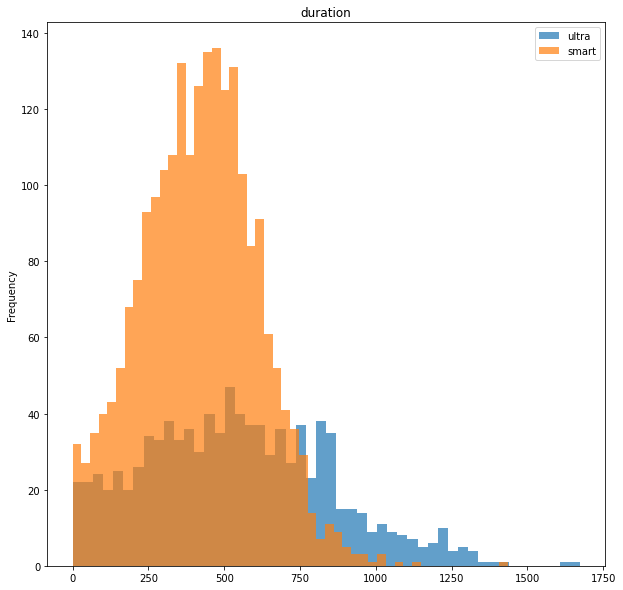

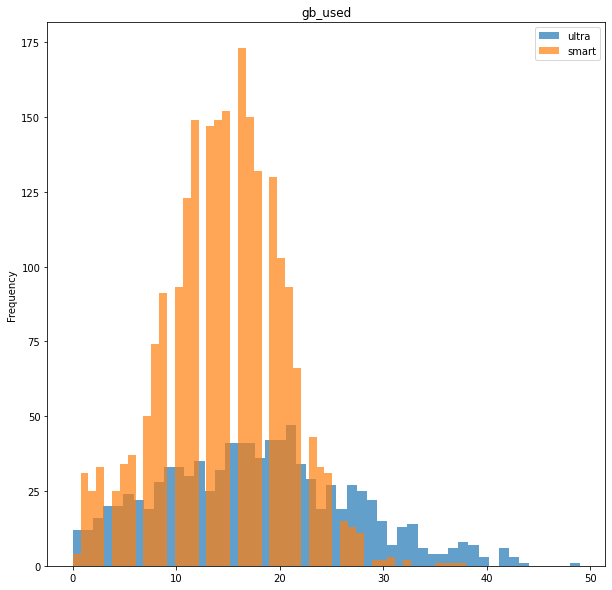

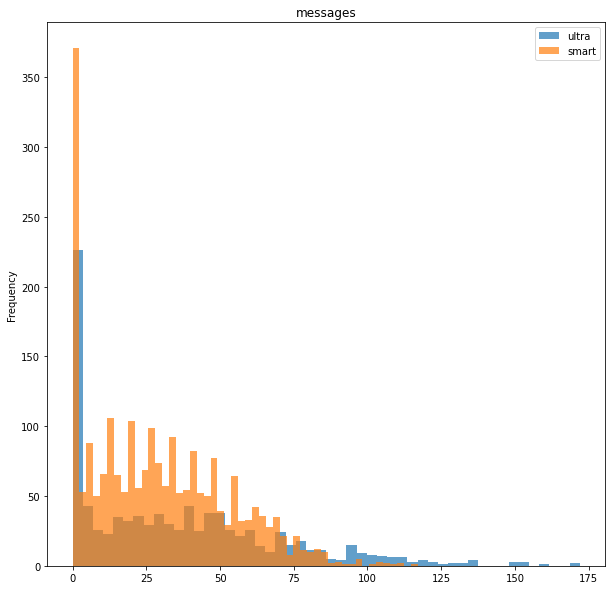

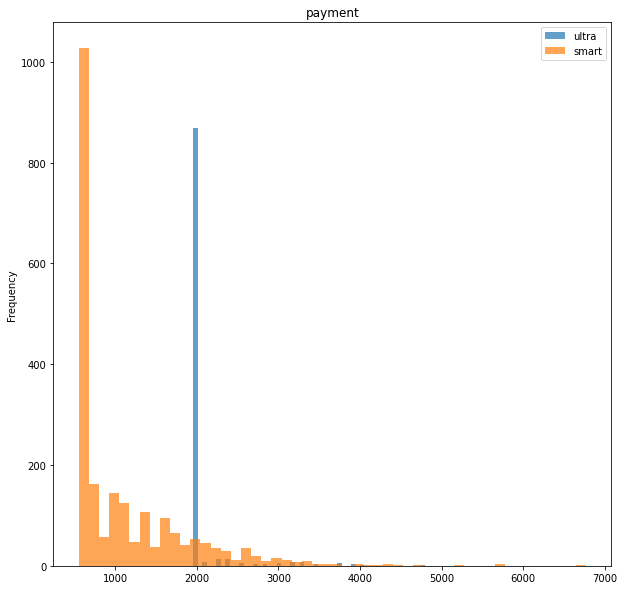

In [21]:
plot_hist(general_usage, *('duration', 'gb_used', 'messages', 'payment'))

##### Вывод

Распределения по тарифу **Смарт**:
* Продолжительность разговора - **нормальное**, в основном от 200 до 700 минут. 
* Интернет-трафик - **нормальное**, от 20 до 60 ГБ. 
* Количество сообщений - **Пуассона**, от 0 до 80. 
* Выручка - **Пуассона**, от 2000 до 10000 тысяч рублей. 

Распределения по тарифу **Ультра**:
* Продолжительность разговора - близко к  **Пуассона**, от 100 до 800 минут. 
* Интернет-трафик - **нормальное**, от 20 до 60 ГБ. 
* Количество сообщений - **Пуассона**, от 0 до 125. 
* Выручка - **Пуассона**, от 2000 до 10000 тысяч рублей. 

В целом на графиках видно, что данных по тарифу **Смарт** гораздо больше. 

## Проверка гипотез

###  Гипотеза 1: Различие между средней выручкой пользователей тарифов «Ультра» и «Смарт»

Определим нулевую гипотезу, как "средняя выручка между тарифами равна", а альтернативную - "средняя выручка отличается". Пороговое значение определим как 0.05, чтобы увеличить точность теста до 95%.

* Ho - Средняя выручка между тарифами равна

* H1 - Средняя выручка отличается

Для проведения исследования используем **ttest_ind** из библиотеки **scipy**, потому что имеем 2 независимые генеральные совокупности. 

In [22]:
alpha = .05
result = st.ttest_ind(general_usage.query('tariff == "smart"')['payment'], 
                      general_usage.query('tariff == "ultra"')['payment'])

print('p-значение:', result.pvalue)

if (result.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 4.057212830695063e-248
Отвергаем нулевую гипотезу


Тест показал, что нулевая гипотеза должна быть **отвергнута**, значит, какой-то тариф может приносить больше денег.
Посчитаем конверсию по каждому тарифу. Найдем сколичество пользователей и суммарную доходность для каждого тарифа:

In [23]:
general_usage.pivot_table(index='tariff', values='payment', aggfunc=['count', 'sum'])

,count,sum
,payment,payment
tariff,,
smart,2223,2434120.0
ultra,951,1927350.0


Посчитаем конверсию:

Для тарифа **смарт**

In [24]:
2223 / 11896320

0.00018686450936087798

Для тарифа **ультра**

In [25]:
952 / 3256650

0.0002923249351327284

Получается, что хоть и пользователей тарифа **ультра** меньше, денег с каждого пользователя он приносит больше. 

### Гипотеза 2: Различие между средней выручкой пользователей из Москвы и выручкой пользователей из других регионов

Определим нулевую гипотезу, как "средняя выручка по пользователям из Москвы и других регионов равна", а альтернативную - "средняя выручка отличается". Пороговое значение определим как 0.05, чтобы увеличить точность теста до 95%.

* Ho - средняя выручка по пользователям из Москвы и других регионов равна
* H1 - средняя выручка отличается

Для проведение исследования используем **ttest_ind** из библиотеки **scipy**, потому что имеем 2 независимые генеральные совокупности.

In [26]:
result = st.ttest_ind(general_usage.query('city == "Москва"')['payment'], 
                      general_usage.query('city != "Москва"')['payment'])

print('p-значение:', result.pvalue)

if (result.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.27392090470432173
Не получилось отвергнуть нулевую гипотезу


##### Вывод

Статистические тесты показали, что средняя выручка по тарифам отличается. Средняя выручка по регионам не различается. Дополнительное исследование показало, что тариф **ультра** приносит больше денег. 

## Общий вывод

В рамках исследования мы изучали поведение пользователей в зависимости от тарифа в месяц:

Поведение по тарифу **Смарт**:
* Продолжительность разговора от 200 до 700 минут. 
* Интернет-трафик от 20 до 60 ГБ. 
* Количество сообщений от 0 до 80. 
* Выручка от 2000 до 10000 тысяч рублей. 

Поведение по тарифу **Ультра**:
* Продолжительность разговора от 100 до 800 минут. 
* Интернет-трафик от 20 до 60 ГБ. 
* Количество сообщений от 0 до 125. 
* Выручка от 2000 до 10000 тысяч рублей. 

Средние значения по таблице:
* смарт: минут разговора - **419**, интернет-трафика - **37**, сообщений - **29**, выручка - **5351**
* ультра: минут разговора - **545**, интернет-трафика - **34**, сообщений - **36**, выручка - **3424**

Поведение пользователей в целом не отличается, однако средняя выручка и интернет-трафик по тарифу "смарт" выше, а "ультра" лидирует по минутам разговора и сообщениям. Проверка гипотез показала, что выручка по тарифам отличается - тариф "ультра" может приносить больше денег. Средняя выручка по центру и регионам не различается. 

Так как поведение пользователей в целом не различается, а тариф "ультра" приносит больше денег с каждого пользователя, на **главный** вопрос исследования можно ответить так - тариф "ультра" может быть более выгоден как компании, так и пользователям. 